# Clustering

When you don't know the groups beforehand, clustering gathers similar observations into groups according to the geometry of data scatters, like penguins shuffle themselves into clusters according to how they look. This notebook covers three main clustering approaches.

| Method | Type | How it works | Best for |
|--------|------|--------------|----------|
| **Hierarchical Clustering (HCA)** | Bottom-up | Builds a tree of nested clusters | Exploring relationships, small-medium datasets |
| **K-Means** | Partition-based | Assigns points to K cluster centers | Large datasets, spherical clusters, when K is known |
| **DBSCAN** | Density-based | Finds dense regions separated by low-density areas | Arbitrary shapes, automatic cluster count, outlier detection |

Let's explore all three methods using the penguins dataset.

In [1]:
// Setup DOM for plotting in Jupyter with Deno
import { Window } from 'https://esm.sh/happy-dom@12.10.3';
const window = new Window();
globalThis.document = window.document;
globalThis.HTMLElement = window.HTMLElement;

// import packages
import * as ds from "../../src/index.js";
import * as Plot from "@observablehq/plot";
import * as d3 from 'npm:d3'

// data
const penguinsResponse = await fetch(
  'https://cdn.jsdelivr.net/npm/vega-datasets@2/data/penguins.json',
);
const penguinsDataRaw = await penguinsResponse.json();
const penguinsData = penguinsDataRaw // there is a row with a "." instead of null in the Sex field
  .map(row => row.Sex === '.' ? { ...row, Sex: null } : row)
  .filter(row => row.Sex);

console.table(penguinsData.slice(0, 5));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │
│     2 │ "Adelie" │ "Torgersen" │ 40.3             │ 18              │ 195                 │ 3250          │ "FEMALE" │
│     3 │ "Adelie" │ "Torgersen" │ 36.7             │ 19.3            │ 193                 │ 3450          │ "FEMALE" │
│     4 │ "Adelie" │ "Torgersen" │ 39.3             │ 20.6            │ 190                 │ 3650          │ "MALE"   │
└───────┴──────────┴────────────

In [2]:
const numeric_fields = [
  "Beak Length (mm)",
  "Beak Depth (mm)",
  "Flipper Length (mm)",
  "Body Mass (g)"
]

## Hierarchical clustering

Start with every penguin alone. Then, step by step, the most resembling individuals regroup, then the closest groups regroup and so on until they become a single group. Each merge creates a branch, and together they form a hierarchical dendrogram, a family tree of similarity. There is no unique way to group individuals. Different linkage functions exist for different purposes.

| Linkage      | What it means                                              | Typical use case                                                                                                                           |
| ------------ | ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| Single   | distance between nearest neighbors                     | To find elongated or chain-like clusters (e.g. rivers, coastlines). Sensitive to noise and chaining effects.                  |
| Complete | distance between farthest points                       | Produces compact, evenly sized clusters; robust to outliers. Useful when you want tight, clearly separated groups.                 |
| Average  | mean distance between all pairs of points              | A balanced compromise between Single and Complete; works well for moderate noise or when cluster shapes are mixed.                 |
| Ward     | merges clusters that increase total variance the least | Favors spherical, equally sized clusters; ideal for quantitative variables and often used in ecological or morphological data. |


In [3]:
const penguinsSample = d3.shuffle(penguinsData.slice()).slice(0, 80)

In [4]:
const hcaEstimator = new ds.ml.HCA({
    linkage: "ward" // Options: 'single', 'complete', 'average', 'ward'
});
hcaEstimator.fit({
    data: penguinsSample,
    X: numeric_fields
});
undefined; // to avoid large output from jupyter

In [5]:
const dendrogramRenderer = ds.plot.createD3DendrogramRenderer(d3, {
  distanceScale: "log10",
  labelOrientation: "horizontal"
})

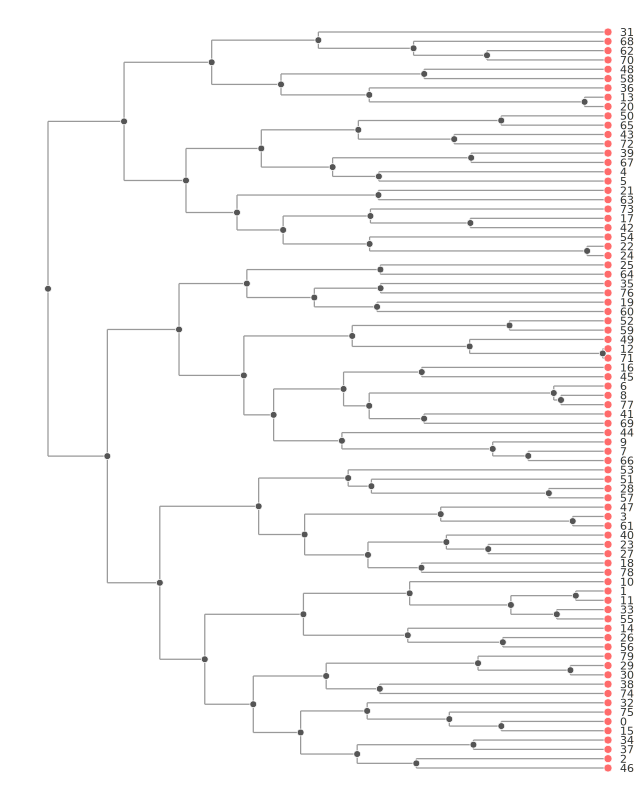

In [6]:
ds.plot.plotHCA(hcaEstimator.model).show(dendrogramRenderer, {
  config: { orientation: "horizontal", height: 800 }
})

The dendrogram is a tree diagram showing how clusters diverge from left to right (or merged from rigth to left). The length of the ranches indicate the group variance. To obtain the grouping, you either cut at a chosen height of the dendrogram, or selecting the number of group you want.

In [7]:
const hcaLabels = hcaEstimator.cut(3) // Cut into N clusters, cutHeight(N) can also be used

### Silhouette

To check how well each penguin fits its assigned group, we can compute a silhouette score with

$$
s_i = \frac{b_i - a_i}{\max(a_i, b_i)},
$$

where $a_i$ is the average distance to its own cluster and $b_i$ is the average distance to the nearest other cluster.

Values close to 1 mean the penguin is comfortably inside its group. Values near 0 mean it stands on the border. Negative values mean it might prefer another flock.

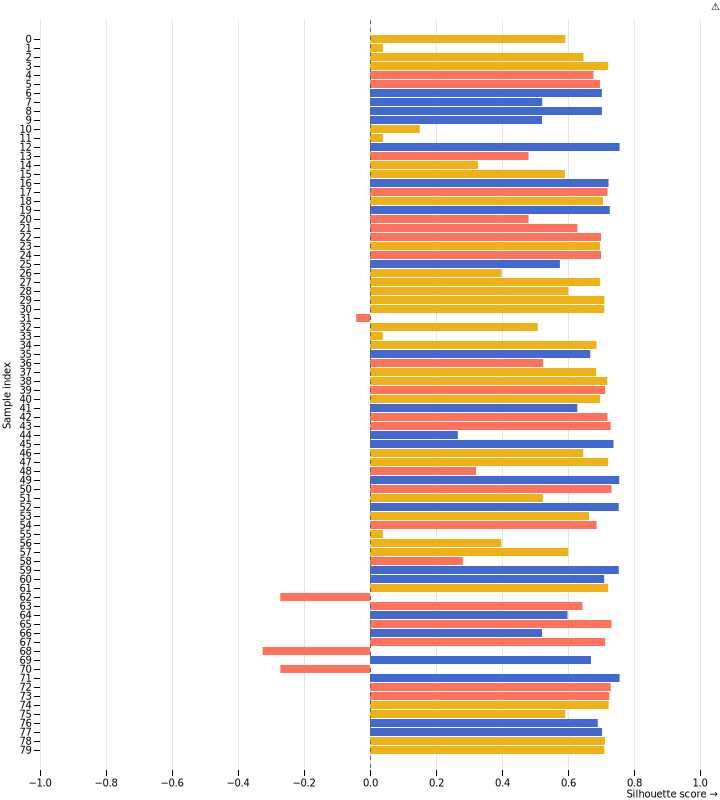

In [8]:
const silhouettePlot = ds.ml.silhouette.silhouetteSamples(
  {
    data: penguinsSample,
    columns: numeric_fields // the numeric columns you clustered on
  },
  hcaLabels
)

ds.plot
  .plotSilhouette({ samples: silhouettePlot }, { height: 800 })
  .show(Plot)

## K-Means clustering

You place each penguin in the variable space according to their characteristics. The you scatter *k* pebbles among the penguins. You assign each penguin to the closest pebble, then you measure the distances between the penguins and their closest pebble. You sequentially move the pebbles to minimize the distances.

Here are the steps

1. Randomly place K cluster centers (centroids)
2. Assign each point to the nearest centroid
3. Recalculate centroids as the mean of assigned points
4. Repeat steps 2-3 until convergence (centroids stop moving)

The key parameters are

- `k`: Number of clusters (must be specified!)
- `max_iter`: Maximum iterations before stopping
- `tol`: Convergence tolerance (stop when centroid movement < tol)
- `random_state`: Seed for reproducibility (K-means is random!)
- `standardize`: Scale features to same range (critical when mixing units like mm and grams!)

In [9]:
const kmeansEstimator = new ds.ml.KMeans({
    k: 3,
    max_iter: 300,
    tol: 1e-4,
    random_state: 42
}).fit({
    data: penguinsData,
    columns: numeric_fields,
    standardize: true // to compare different metrics, like mm and grams
});
undefined;

In [10]:
const penguinsWithLabels = penguinsData.map((d, i) => ({
  ...d,
  clusterK: String("Group " + kmeansEstimator.labels[i])
}))

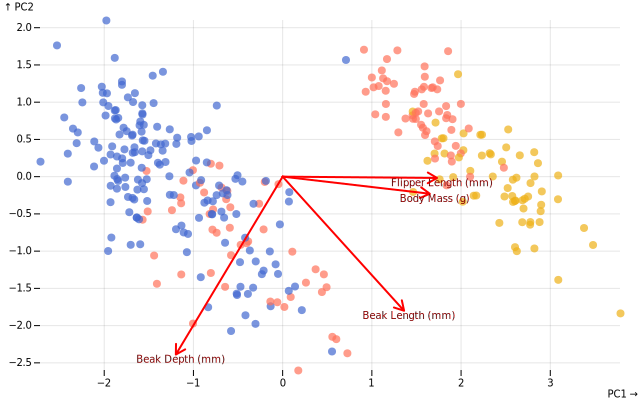

In [11]:
const pcaEstimator = new ds.mva.PCA({
    nComponents: 2,
    scale: true,
    center: true,
    scaling: 1
}).fit({
    data: penguinsData
});

ds.plot.ordiplot(pcaEstimator.model, {
  colorBy: penguinsWithLabels.map((d) => d.clusterK)
}).show(Plot);


We used a PCA to visualize the clusters in 2D space. The colors show the K-means cluster assignments. We should look for

- tight, separated groups: Good clustering—groups are distinct,
- overlapping colors: Some ambiguity—observations on cluster boundaries, and
- cluster size: Are groups roughly balanced, or is one cluster much larger.

Clustering is exploratory—there's no single "correct" answer. The best clustering depends on your research question and domain knowledge.

## DBSCAN

Unlike K-Means and HCA, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) doesn't require you to specify the number of clusters beforehand. Instead, it discovers clusters by finding dense regions in the data. Penguins that are closed together (high density) belong to the same cluster, and lone penguins wandering far from any flock are considered outliers (noise).

Here is how DBSCAN works, step by step.

1. For each penguin, count how many other penguins are within `eps` distance (the neighborhood radius)
2. If a penguin has at least `minSamples` neighbors, it's a **core point** (part of a dense region)
3. Penguins that can reach a core point (within `eps`) join that cluster
4. Penguins that can't reach any cluster are labeled as noise (outliers)

DBSCAN are almost always better than k-means. They automatically determines the number of clusters (very sensible to the parameters, though), they find arbitrarily shaped clusters (not just spherical), they identify outliers as noise and they are deterministic (same result every time).

In [12]:
// First, let's standardize the features since eps is distance-based
const scaler = new ds.ml.preprocessing.StandardScaler().fit({
  data: penguinsData,
  columns: numeric_fields
});

const penguinsScaled = scaler.transform({
  data: penguinsData,
  columns: numeric_fields
});

// Fit DBSCAN
const dbscanEstimator = new ds.ml.DBSCAN({
  eps: 0.65,        // Experiment with this: smaller = tighter clusters
  minSamples: 10    // Minimum points to form a dense region
});

dbscanEstimator.fit({
  data: penguinsScaled.data,
  columns: numeric_fields
});

// Check what DBSCAN found
dbscanEstimator.summary();

{
  eps: 0.65,
  minSamples: 10,
  nClusters: 3,
  nNoise: 36,
  nSamples: 333,
  nCore: 3,
  noiseRatio: 0.10810810810810811,
  coreRatio: 0.009009009009009009
}

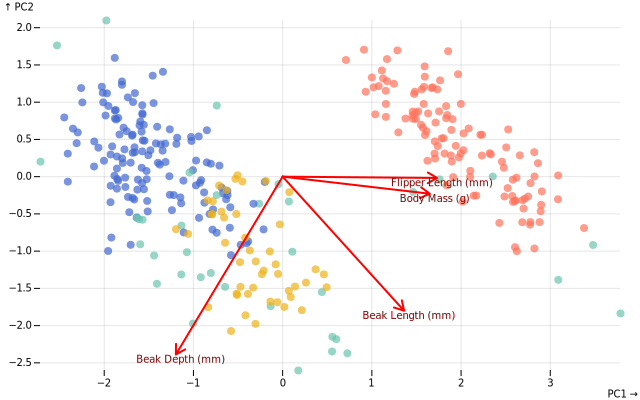

In [13]:
// Visualize DBSCAN clusters
// Label -1 means noise, 0+ means cluster ID
const penguinsWithDBSCAN = penguinsData.map((d, i) => ({
  ...d,
  clusterDBSCAN: dbscanEstimator.labels[i] === -1 
    ? 'Noise' 
    : String('Cluster ' + (dbscanEstimator.labels[i]))
}));

ds.plot.ordiplot(pcaEstimator.model, {
  colorBy: penguinsWithDBSCAN.map((d) => d.clusterDBSCAN)
}).show(Plot);

As said, the class attribution highly depends on the two key parameters. When  the neighborhood radius `eps` is too high, points merge into few clusters - too small, everything becomes noise or tiny clusters. Penguins is a fictive case, where we have the species information, in theory using DBSCAN on them doesn't make much sense outside understanding the method. In real cases, plotting the distribution of pairwise distances might help to set a reliable `eps`. When the minimum points for a dense region `minSamples` is too small, noise becomes clusters, ans when it's too large, real clusters become noise. Rule of thumb, use `minSamples ≥ dimensions + 1` (for 4 features, try 5-10). More stable clustering can be made with HDBSCAN (hierarchical DBSCAN), but `tangent/ds` doesn't have it yet. For more stability, multiple clustering methods can be used with an *ensemble* perspective.

## Ensemble clustering

Different clustering algorithms may find different patterns in the data. Instead of choosing one, we can combine multiple models to get more robust, consensus clusters.

In [32]:
const consensus = new ds.ml.ConsensusCluster({
  estimators: [
    new ds.ml.HCA({ linkage: "average", k: 4 }),
    new ds.ml.KMeans({ k: 5, seed: 123 }),
    new ds.ml.DBSCAN({ eps: 0.6, minSamples: 10 })
  ],
  threshold: 0.5
});

// Works directly with table format - no need for prepareX()
consensus.fit({
  data: penguinsScaled.data,
  columns: numeric_fields
});

consensus.summary();

{
  fitted: true,
  nEstimators: 3,
  threshold: 0.5,
  nClusters: 6,
  nNoise: 0,
  nSamples: 333,
  noiseRatio: 0,
  overallAgreement: 0.2840310189707681,
  avgConsensusStrength: 0.7867113644405427,
  clusterStrengths: {
    "0": 0.6713856713856725,
    "1": 0.7267451783580818,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 0.9565114181265719
  }
}

The consensus strength is pretty high at 0.79, with clusters 2, 3 and 4 having unanimity. The overall agreement is pretty low, which is expected since they have a different number of clusters.

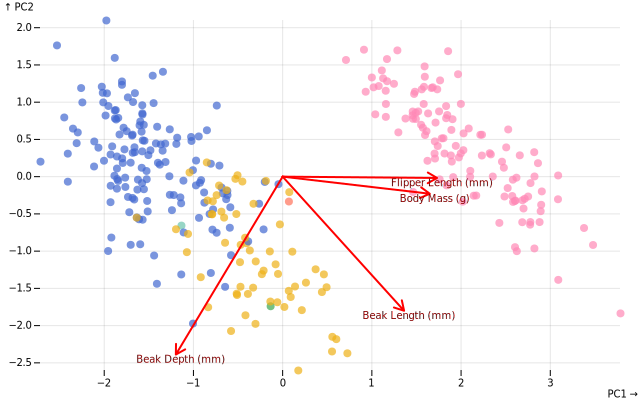

In [33]:
// Visualize consensus clusters
const penguinsWithConsensus = penguinsData.map((d, i) => ({
  ...d,
  consensus: consensus.labels[i] === -1 
    ? 'Noise' 
    : String('Cluster ' + consensus.labels[i])
}));

ds.plot.ordiplot(pcaEstimator.model, {
  colorBy: penguinsWithConsensus.map(d => d.consensus)
}).show(Plot);

The ensemble clustering fits each model, builds a co-association matrix (for each pair of points, count how many models put them in the same cluster), converts to agreement ratio (0 = never together, 1 = always together) amd finally clusters the similarity matrix using the final clusterer. The result more robust and less sensible than any single algorithm.